# ANÁLISE DOS REGISTROS DO SISTEMA COMANDO DE OCORRÊNCIAS COM ORIGEM METEOROLÓGICA

### Importar modulos e funções

In [399]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, requests, json, folium
import seaborn as sns; sns.set()
from folium import plugins
from IPython.display import Image

### Definir classe 'data' com endereço dos dados
class data:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Carregando dados

In [2]:
comando = pd.read_csv(data.path + 'comando.csv') 

c:\Users\luisr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
comando.head(2)

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_GRAVIDADE,EVENTO_BAIRRO,STATUS,EVENTO_INICIO,EVENTO_INICIO_HORA,EVENTO_FIM,EVENTO_FIM_HORA,EVENTO_PRAZO,EVENTO_LATITUDE,EVENTO_LONGITUDE,POP_TITULO,POP_DESCRICAO,ORGAO_SIGLA,ORGAO_NOME,ACAO
0,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23,12:13:00,2015-02-23,14:18:00,NaN,0.0,0.0,Acidente com vítima(s),Acidente com vítima(s),CET-RIO,Companhia de Engenharia de Tráfego,Desfazer o acidente
1,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23,12:13:00,2015-02-23,14:18:00,NaN,NaN,0.0,Acidente com vítima(s),Acidente com vítima(s),CET-RIO,Companhia de Engenharia de Tráfego,Organizar o trânsito


---
# Busca de registros por título

Roteiro:
1. Quais pontos tem mais ocorrências?
2. Do ponto que tem mais ocorrência, qual foi a última?
3. Média de ações por ocorrência.
4. Ocorrências com mais ações.
5. Quais são as principais ações e quem são os órgãos mais acionados!??
6. Qual estágio de alerta estava a cidade do rio na maioria desses chamados de bolsões de água?
7. Quanto mm de chuva havia no registro pluviométrico!?
    

In [4]:
titles = [
    "Bolsão d'água em via", 'Vazamento de água / esgoto',
    'Alagamentos e enchentes', "Lâmina d'água",
    "Lâmina d'água em via", 'Alagamento',
    'Enchente', 'Bueiro'
]

records = comando[comando['POP_TITULO'].isin(titles)]

events = records.groupby('EVENTO_ID').first() # Isolndo ocorrências (primeiro registro de cada ocorrência)

print(records.shape) # Número total de registros encontrados
print(events.shape) # Número eventos de registros encontrados

(12409, 18)
(4884, 17)


---
# Análise exploratória do resultado da busca

### Contagem de registros e ocorrências meteorológicas

In [286]:
records_count = records['POP_TITULO'].value_counts() # Contagem registros por tipo

In [488]:
records_count

Bolsão d'água em via          8956
Vazamento de água / esgoto    1707
Alagamento                     821
Alagamentos e enchentes        574
Lâmina d'água                  260
Bueiro                          75
Enchente                        16
Name: POP_TITULO, dtype: int64

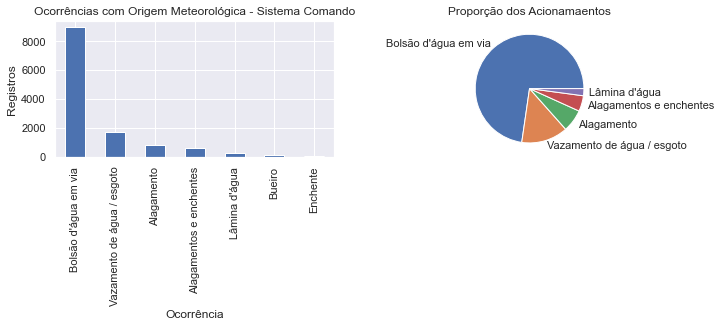

In [286]:
# display(records_count)
fig, ax = plt.subplots(1, 2)
records_count.plot.bar(figsize=(11, 2.5), ax=ax[0])
ax[0].set(ylabel='Registros', xlabel='Ocorrência', title='Ocorrências com Origem Meteorológica - Sistema Comando')
# plt.savefig('plots/contagem_registros.png')
# plt.show()

# event_count = records.groupby('EVENTO_ID').first()['POP_TITULO'].value_counts() # Contagem eventos por título
# # ax = plt.subplot()
# event_count.plot.bar(ax=ax[1])
# ax[1].set(ylabel='Registros', xlabel='Ocorrências meteorológicas', title='Contagem de ocorrências de origem\nmeteorológica do Sistema Comando')
# # plt.savefig('plots/contagem_ocorrências.png')
# plt.show()

### Proporção de registros meteorológicas

# display(records_count)
# fig, ax = plt.subplots()
records_count.drop(['Enchente', 'Bueiro']).plot.pie(ax=ax[1])
ax[1].set(ylabel='', title='Proporção dos Acionamaentos')
plt.savefig('plots/proporção_registros.png')
plt.show()

### Média de ações por ocorrência e por tipo

In [120]:
records.groupby('EVENTO_ID').count().mean().round(2).iloc[0] # Média geral de 2,5 ações por ocorrência

2.54

In [289]:
print('Média Nº de ações por tipo de ocorrência:\n')
avg_df = []
for title in records['POP_TITULO'].unique():
    avg = records.set_index('POP_TITULO').loc[title].groupby('EVENTO_ID').count().mean().iloc[0] # Média de 2,5 ações por ocorrência
    
    
    avg_df.append([title, round(avg, 1)])
#     print(f'{title}: {round(avg, 1)}')
avg_df = pd.DataFrame(avg_df, columns=['Tipo de Ocorrência', 'Média de Acões']).sort_values('Média de Acões', ascending=False)
display(avg_df)

Média Nº de ações por tipo de ocorrência:



,Tipo de Ocorrência,Média de Acões
2,Alagamentos e enchentes,3.3
5,Enchente,3.2
1,Vazamento de água / esgoto,3.1
4,Alagamento,3.1
0,Bolsão d'água em via,2.4
6,Bueiro,2.1
3,Lâmina d'água,1.8


In [114]:
avg = records.set_index('POP_TITULO').loc[title].groupby('EVENTO_ID').count()# Média de 2,5 ações por ocorrência
avg.describe().iloc[:, 0][['mean', '50%']].rename(title)

### Ocorrências com maior número de ações e acionamentos de orgãos (top 10)

In [238]:
top_ocorr = records.groupby('EVENTO_ID').count()['EVENTO_TITULO'].nlargest(10).rename('Ações Realizadas')
top_desc = records.set_index('EVENTO_ID').loc[top_ocorr.index].groupby('EVENTO_ID').first()[['EVENTO_DESCRICAO', 'EVENTO_INICIO', 'POP_TITULO', ]]
display(pd.concat([top_desc, top_ocorr], 1).sort_values('Ações Realizadas', ascending=False))

# pd.set_option('max_rows', None)
# display(records.set_index('EVENTO_ID').loc[top_ocorr.index])
# Descomente para conferir lista completa de acionamentos e ações das ocorrências mais requisitadas

,EVENTO_DESCRICAO,EVENTO_INICIO,POP_TITULO,Ações Realizadas
EVENTO_ID,,,,
69549,"Avenida de Santa Cruz, Alt. Universidade Caste...",2021-12-23,Bolsão d'água em via,18
13328,"Estr. do Lameirão, 1030 - Santíssimo - Alt. R....",2017-01-04,Vazamento de água / esgoto,16
17726,"Rua Pinheiro Guimarães,336 - Botafogo.",2017-06-12,Vazamento de água / esgoto,13
51786,"R. Apiacás, 194 - Taquara",2020-03-01,Alagamentos e enchentes,13
51792,Av. Brasil - Alt. da Passarela 27 - Irajá - Se...,2020-03-01,Alagamentos e enchentes,13
51801,"R. Pedro Tenório, 36 - Irajá",2020-03-01,Alagamentos e enchentes,13
51802,"Praia Dos Tamoios, 611 - Paquetá",2020-03-01,Alagamentos e enchentes,13
51917,Av. Alto Maranhão - Guaratiba,2020-03-01,Alagamentos e enchentes,13
51918,Av. Canal dois - Recreio dos Bandeirantes,2020-03-01,Alagamentos e enchentes,13


### Principáis ações

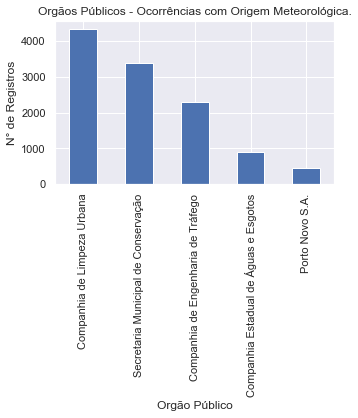

In [280]:
orgaos_count = records['ORGAO_NOME'].value_counts()
ax = (orgaos_count).round(1).head(5).plot.bar(
    title='Orgãos Públicos - Ocorrências com Origem Meteorológica.',
    figsize=(5, 3)
)
ax.set(
    ylabel='N° de Registros', xlabel='Orgão Público'
); plt.show()

### Principais orgãos acionados

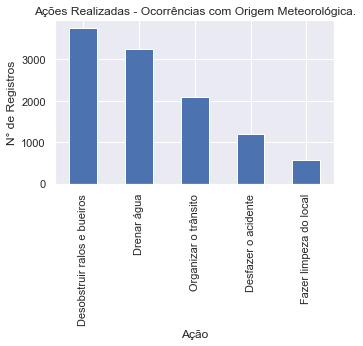

In [281]:
orgaos_count = records['ACAO'].value_counts()
ax = (orgaos_count).round(1).head(5).plot.bar(
    title='Ações Realizadas - Ocorrências com Origem Meteorológica.',
    figsize=(5, 3)
)
ax.set(
    ylabel='N° de Registros', xlabel='Ação'
); plt.show()

---
# Tratamento dos dados de coordenadas

#### Funções de tratamento/formatação de coordenadas

In [ ]:
def orderOfMagnitude(number):
    return np.floor(np.log10(abs(number)))

def correct_magnitude(number, mag=1):
    if type(number)!=list:
        magnitude = orderOfMagnitude(number)
        return number / 10 ** ( orderOfMagnitude(number) - mag )
    else:
        return [correct_magnitude(n, mag) for n in number]

def encode_coords(coords):
    return str(coords[0]) + ',' + str(coords[1])

nan_filter = lambda coord: 'nan' not in coord
nan_list_filter = lambda coord: not np.isnan(coord[0]) and not np.isnan(coord[1])
incomplete_values = [-23.0, -22.8, -22.9]
incomplete_coord_filter = lambda coord: coord[0] not in incomplete_values and coord[1] not in incomplete_values

#### Tratando coordenadas das ocorrências

In [ ]:
events['lat'], events['lng'] = (correct_magnitude(events[col].tolist(), mag=1) for col in ('EVENTO_LATITUDE', 'EVENTO_LONGITUDE'))

coords_raw = list(zip(
    events['lat'].tolist(),
    events['lng'].tolist()
))

coords = list(filter(nan_list_filter, coords_raw))
coords = list(filter(incomplete_coord_filter, coords))

n_markers = 150

coords_txt = '|'.join( list(map(encode_coords, coords))[10: n_markers] )

len(coords_raw) - len(coords) # coordenadas faltando

---
# Visualizando Ocorrências no Mapa

## Funções para gerar mapas

In [489]:
def plot_markers(
    df, center=[-22.9037, -43.4276], zoom=10,
    radius=3, colors=colors,
    exclude=["Bolsão d'água em via"],
    touch_coord=True
):

    m = folium.Map(location=center, zoom_start=zoom, width='80%', height='80%')

    for index in df.index:
        event = df.loc[index]; coord = event.loc[['lat', 'lng']]
        event_type = event['POP_TITULO']
        valid_coord = event_type not in exclude and coord.isna().sum()==0 and not coord.isin(incomplete_values).any()
        if valid_coord:
            folium.CircleMarker(
                location=list(coord), radius=radius,
                color=colors[event_type], opacity=1,
                fill=True, fill_color=colors[event_type],
                fill_opacity=1,
            ).add_to(m)

    if touch_coord: m.add_child(folium.LatLngPopup())
    return m

def heatmap(
    points, center=[-22.9037, -43.4276], zoom=10,
    min_opacity=0.5, max_zoom=18, max_val=1.0,
    radius=25, blur=15, gradient=None,
):

    m = folium.Map(location=center, zoom_start=zoom, width='80%', height='80%')

    plugins.HeatMap(
        points, min_opacity=min_opacity, max_zoom=max_zoom,
        max_val=max_val, radius=radius, blur=blur,
        gradient=gradient,
    ).add_to(m)
    
    return m

## Mapas de Pontos

In [343]:
colors = {
    "Bolsão d'água em via": 'red',
    'Alagamentos e enchentes': 'blue',
    'Alagamento': 'blue',
    'Enchente': 'blue',
    "Lâmina d'água": 'red',
    "Lâmina d'água em via": 'red',
    'Vazamento de água / esgoto': 'green',
    'Bueiro': 'green'
}

#### Bolsões

In [490]:
plot_markers(
    events, center=[-22.9037, -43.4276], zoom=10, radius=2,
    colors=colors, exclude=titles[1:], touch_coord=True
)

#### Outros tipos de ocorrência

In [491]:
plot_markers(
    events, center=[-22.9037, -43.4276], zoom=11, radius=3,
    colors=colors, exclude=titles[:1],
    touch_coord=True
)

# Mapas de calor (Hotspot)

In [346]:
valid_row = lambda row: row[['lat', 'lng']].isna().sum()==0 and not row[['lat', 'lng']].isin(incomplete_values).any()

### HotSpot Geral

In [492]:
points =  [[row['lat'], row['lng']] for index, row in  events.iterrows() if valid_row(row)]

In [590]:
m = heatmap(
        points, zoom=11,
#         min_opacity=.7,
#         max_zoom=15,
        max_val=.3,
        radius=8,
        blur=10,
)

display(m)

## HotSpot por tipo de ocorrências

#### Configurações

In [501]:
bolsoes = [
    "Bolsão d'água em via",
]
alagamentos = [
    'Alagamentos e enchentes',
    'Alagamento',
#     'Enchente',
]
laminas = [
    "Lâmina d'água",
    "Lâmina d'água em via",
]
vazamentos = [
    'Vazamento de água / esgoto',
    'Bueiro',
]

cat_groups = [bolsoes, alagamentos, laminas, vazamentos]

cats_gradients = [
    None,
    {0.5: 'yellow', 0.75: 'purple'},
    {0.5: 'yellow', 0.7: 'green'},
    {0.5: 'blue', 1: 'yellow'},
#     {0: 'blue', 0.7: 'red'},
]

def filter_data(data, col, cats):
    return data[data[col].isin(cats)].copy()

#### Mapa de calor para cada tipo de ocorrência

In [591]:
for i, cats in enumerate(cat_groups):
    data_df = filter_data(events, col='POP_TITULO', cats=cats)
    data = [[row['lat'], row['lng']] for index, row in  data_df.iterrows() if valid_row(row)]
    print(data_df.shape)
    display(heatmap(
        data, zoom=10,
        min_opacity=0.3,
        max_zoom=20,
        max_val=1,
        radius=8,
        blur=3,
        gradient=cats_gradients[i],
    ))

(3715, 19)


(434, 19)


(146, 19)


(584, 19)
